# Pipeline for transforming metadata from Kaggle to Research Processes Curation Metamodel (RPCM) implementation

This notebook details the extraction and transformation process of metadata from the Kaggle platform using its official API to access dataset information and associated attributes.

The pipeline begins by connecting to the Kaggle API, where metadata such as dataset names, descriptions, schemas, tags, and other fields from Kaggle’s metamodel are programmatically extracted. This data is then processed and transformed to generate a bulk set of structured entities compatible with the RPCM metadata model implemented in ATLAS.


This pipeline automates the integration of metadata between Kaggle and RPCM, enabling centralized management, traceability, and data enrichment within data governance environments.



## Kaggle Metamodel

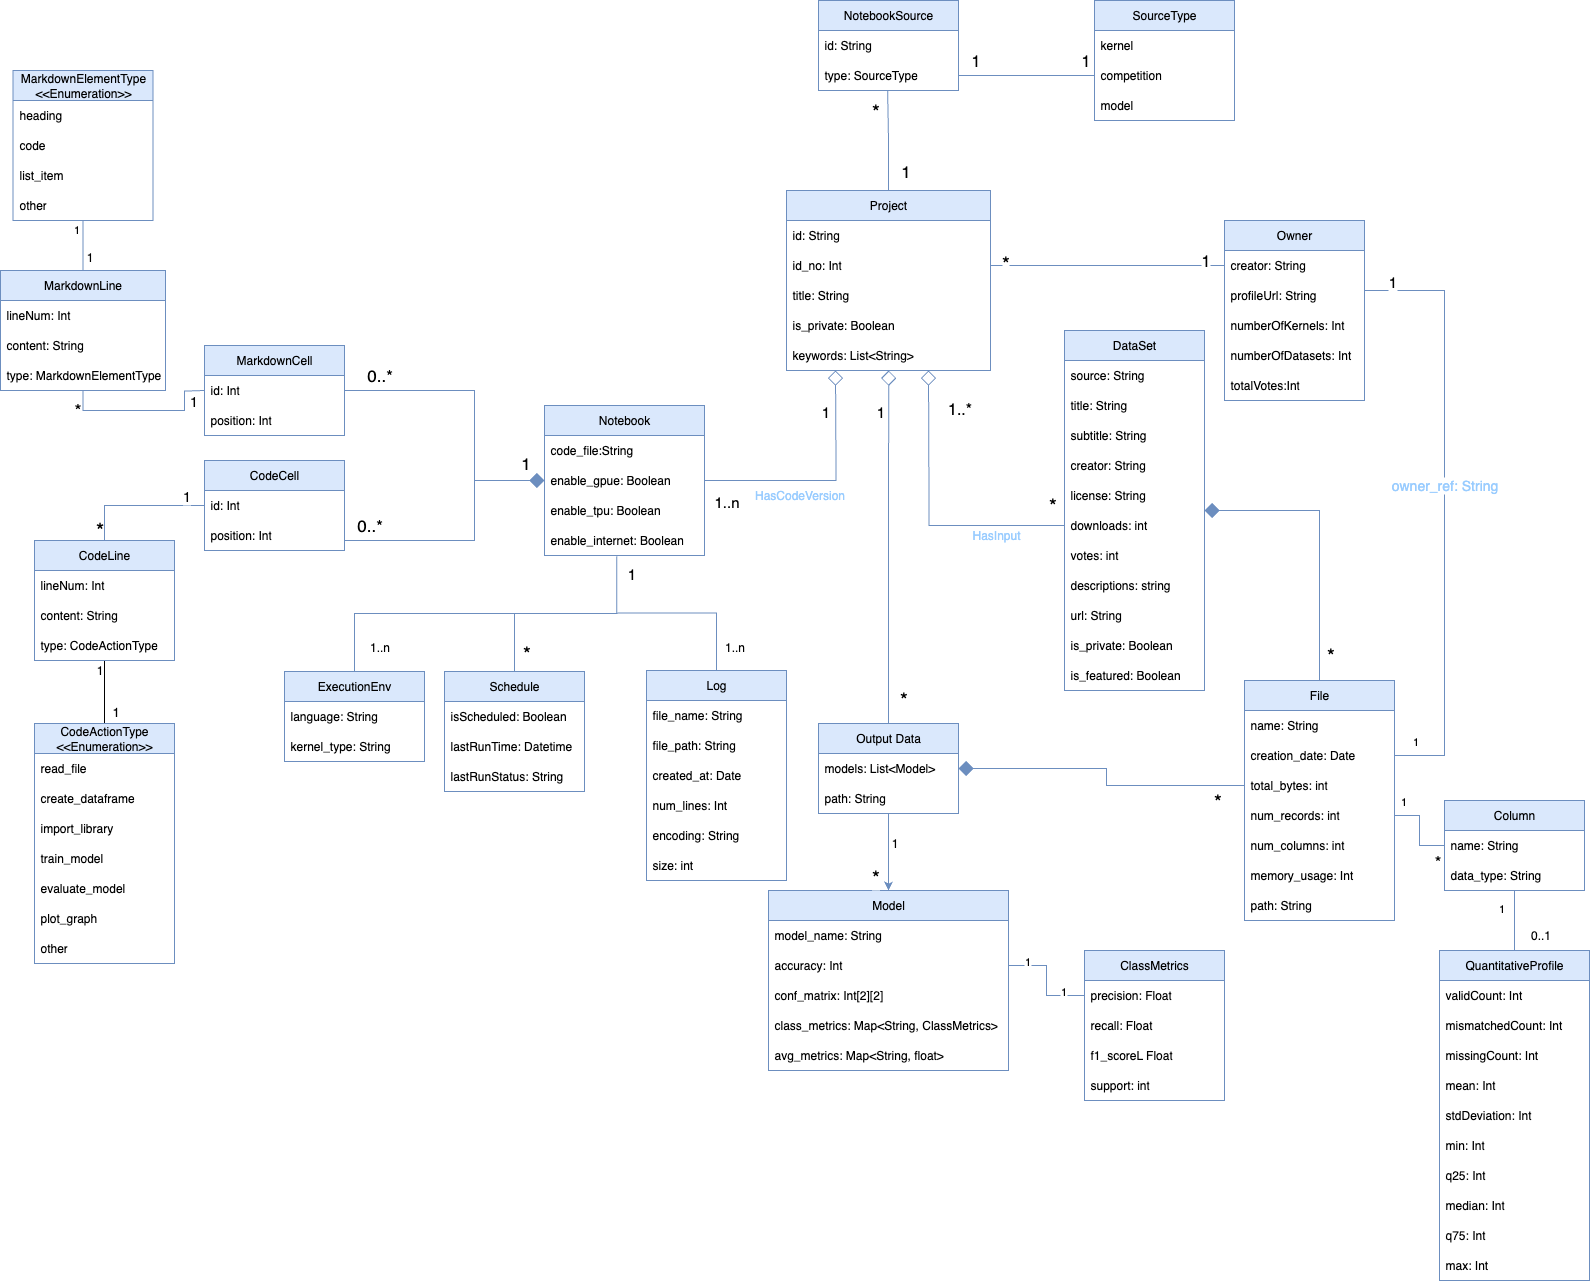

## Research Processes Curation Metamodel (RPCM)

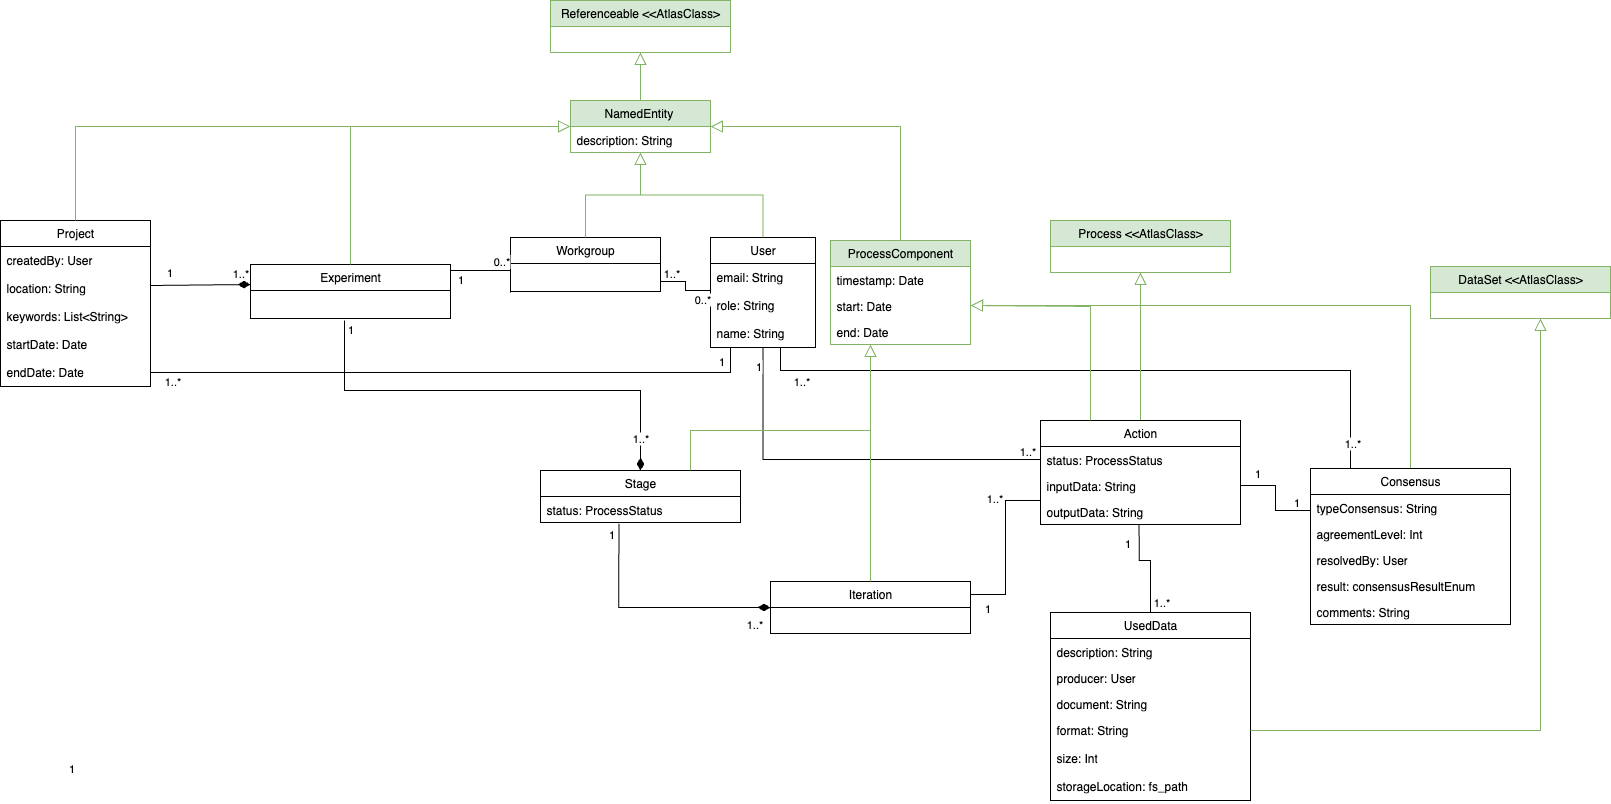

## Kaggle API Settings and Libraries

To use the Kaggle API, it is necessary to create an account on Kaggle and generate an API key. This key will allow us to authenticate and make requests to the Kaggle API.

In [1]:
pip install kaggle

In [3]:
import os
import re
import zipfile
import json
import pandas as pd
import subprocess
import chardet
from datetime import datetime
import uuid
import nbformat
from pathlib import Path
import hashlib
import base64

from kaggle.api.kaggle_api_extended import KaggleApi

In [4]:
os.environ['KAGGLE_USERNAME'] = "abnerasteteh"
os.environ['KAGGLE_KEY'] = "5dec29fba975d4119a37855b3653d27d"

In [5]:
# Authentication
api = KaggleApi()
api.authenticate()

## Download Kaggle Projects

The Kaggle API was used to select and download a list of projects, chosen based on the number of user votes on the platform. These projects were manually reviewed to ensure variety, relevant content for information extraction, and that they were developed in Python. These example projects were selected because they include a diverse set of associated datasets and offer rich content within the notebook.

Using the Kaggle API, the following items were downloaded or retrieved:

* The complete project notebook in .ipynb format.
* The project metadata (kernel-metadata.json).
* The files associated with the datasets used by the project.
* Execution logs of the kernel, when available.
* Insights derived from the analysis and processing of the notebook.

Additionally, data sources used in each project were extracted from the downloaded metadata, creating a DataFrame for identification and further analysis.

## Files and Data Generated

Based on the information obtained (metadata, notebooks, datasets, and logs), structured JSON files were generated to facilitate analysis and integration with external tools:

* entities-kaggle.json: contains an enriched structure with information about the project, owner, datasets, files, logs, and details extracted from the notebook.

* entities-bulk-atlas.json: a file prepared for consumption by the Atlas API, enabling bulk processing of entities related to the project.










In [6]:
# List of Kaggle projects to which the pipeline will be applied,
# The code can run multiple projects at the same time, but the Kaggle API may stop because it has a call limit.
kernel_refs = [
    "joelknapp/student-performance-analysis/",
    #"mfaaris/content-based-and-tensorflow-recommender-system/",
    #"jph84562/the-ugly-truth-of-people-decisions-in-speed-dating",
    #"aremoto/retail-sales-forecast/",
    #"nareshbhat/eda-classification-ensemble-92-accuracy",
    #"fedi1996/boston-crime-analysis-with-plotly",
]

In [7]:
# Creation of the base directory and complementary functions
base_dir = "kaggle_notebooks"
os.makedirs(base_dir, exist_ok=True)

def safe_name(ref):
    return re.sub(r'[^\w\-]', '_', ref)

def gen_guid():
    return f"-{uuid.uuid4().int % 1000000000}"

## Automated Extraction of Kaggle Kernel Outputs - Logs


Here we implements a pipeline that, given a Kaggle kernel, automatically downloads its output files using the Kaggle CLI, then locates and loads the .log file in JSON format to process its content. It uses automatic detection of the file’s encoding to ensure correct reading and specifically extracts the text generated in the standard output stream (stdout). Through regular expressions and line-by-line analysis, it extracts relevant information such as the dataset structure (number of rows, columns, data types, and memory usage), details of trained models (name, accuracy, confusion matrix, and detailed class-level classification metrics), as well as the kernel’s execution times. Additionally, it collects metadata from the log file such as its size, creation date, and number of lines. Finally, it consolidates all this information into a structured JSON called log_analysis.json, thereby facilitating the integration of these data with other systems or enabling further automated and reproducible analysis.


In [8]:
def download_kaggle_output(kernel_ref: str, download_path: str):
    print(f"[INFO] Downloading outputs from: {kernel_ref}")
    subprocess.run([
        "kaggle", "kernels", "output", kernel_ref,
        "-p", download_path
    ], check=True)
    print(f"[INFO] Download completed at: {download_path}")

# ---------- LOAD AND PROCESS JSON LOG ----------
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        return chardet.detect(f.read(100000))['encoding']

def load_log_json(file_path):
    encoding = detect_encoding(file_path)
    with open(file_path, 'r', encoding=encoding) as f:
        return json.load(f), encoding

def extract_text_from_stdout(log_data):
    return ''.join(entry['data'] for entry in log_data if entry['stream_name'] == 'stdout')

# ---------- INFORMATION PARSING ----------
def extract_dataset_info(text):
    info = {}
    match = re.search(r"RangeIndex: (\d+)", text)
    if match:
        info["rows"] = int(match.group(1))
    match = re.search(r"Data columns \(total (\d+) columns\):", text)
    if match:
        info["columns"] = int(match.group(1))
    dtypes = re.findall(r"\d+\s+(\w+)\s+\d+ non-null\s+(\w+)", text)
    info["dtypes"] = {col: dtype for col, dtype in dtypes}
    match = re.search(r"memory usage:\s+([^\n]+)", text)
    if match:
        info["memory_usage"] = match.group(1)
    return info

def extract_models_info(text):
    lines = text.splitlines()
    models = []
    current = {
        "model": None,
        "accuracy": None,
        "conf_matrix": [],
        "class_metrics": {},
        "avg_metrics": {},
    }

    state = None
    pending_matrix = []

    for line in lines:
        line = line.strip()

        if not line:
            continue

        # --- Confusion Matrix ---
        if line.lower().startswith("confussion matrix"):
            state = "conf_matrix"
            pending_matrix = []
            continue
        elif state == "conf_matrix" and "[" in line:
            numbers = list(map(int, re.findall(r"\d+", line)))
            if len(numbers) == 2:
                pending_matrix.append(numbers)
            if len(pending_matrix) == 2:
                current["conf_matrix"] = pending_matrix
                state = None
            continue

        # --- Accuracy ---
        match = re.match(r"Accuracy of (.*?):\s*([\d.]+)", line)
        if match:
            current["model"] = match.group(1).strip()
            current["accuracy"] = float(match.group(2))
            continue

        # --- Start of classification report ---
        if re.match(r"^precision\s+recall\s+f1-score\s+support", line):
            state = "report"
            continue

        if state == "report":
            parts = re.split(r"\s+", line)
            if len(parts) == 5:
                label = parts[0]
                try:
                    metrics = {
                        "precision": float(parts[1]),
                        "recall": float(parts[2]),
                        "f1-score": float(parts[3]),
                        "support": int(parts[4]),
                    }
                    if label in ("0", "1"):
                        current["class_metrics"][label] = metrics
                    elif label in ("macro", "weighted"):
                        # Merge label + " avg"
                        current["avg_metrics"][label + " avg"] = metrics
                except ValueError:
                    pass
            elif "accuracy" in line.lower():
                state = None
                models.append(current)
                current = {
                    "model": None,
                    "accuracy": None,
                    "conf_matrix": [],
                    "class_metrics": {},
                    "avg_metrics": {},
                }

    if current["model"] and current not in models:
        models.append(current)

    return models

def extract_execution_time(log_data):
    times = [entry["time"] for entry in log_data if "time" in entry]
    if not times:
        return {}
    return {
        "start": times[0],
        "end": times[-1],
        "duration_seconds": round(times[-1] - times[0], 3)
    }

def extract_file_metadata(file_path, encoding):
    stat = os.stat(file_path)
    with open(file_path, 'r', encoding=encoding) as f:
        num_lines = sum(1 for _ in f)
    return {
        "filename": os.path.basename(file_path),
        "filepath": os.path.abspath(file_path),
        "created_at": datetime.fromtimestamp(stat.st_ctime).isoformat(),
        "num_lines": num_lines,
        "encoding": encoding,
        "total_bytes": stat.st_size
    }

def analyze_kaggle_log(kernel_ref: str, output_path: str):
    download_kaggle_output(kernel_ref, output_path)

    # Find the downloaded .log file
    log_file = next((f for f in os.listdir(output_path) if f.endswith('.log')), None)
    if not log_file:
        raise FileNotFoundError("No .log file found in the download.")
    log_path = os.path.join(output_path, log_file)

    log_data, encoding = load_log_json(log_path)
    text = extract_text_from_stdout(log_data)

    result = {
        "file_info": extract_file_metadata(log_path, encoding),
        "dataset_info": extract_dataset_info(text),
        "models": extract_models_info(text),
        "execution_time": extract_execution_time(log_data)
    }

    # Display and save result
    #print(json.dumps(result, indent=2, ensure_ascii=False))
    with open(os.path.join(output_path, "log_analysis.json"), "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2, ensure_ascii=False)

##  Extraction of Insights from Jupyter Notebooks

This function parses a Jupyter notebook file to automatically extract key insights about its content. It reads the notebook in JSON format and scans through all its cells to identify and collect information such as the datasets being loaded (specifically from calls to pd.read_csv with paths pointing to input folders), machine learning models referenced (e.g., classifiers like XGBClassifier or SVC), and evaluation metrics used (such as accuracy, F1 score, confusion matrix, and classification reports). Additionally, it detects the presence of visual outputs like graphs by checking for .show() calls or embedded images in the notebook’s output cells. The function also tracks the notebook’s structural sections based on markdown headers, associating each extracted insight with its corresponding section title. All this information is aggregated into a structured dictionary, converting sets to lists for easy JSON serialization, thereby enabling automated analysis and summarization of notebook contents.


In [ ]:
import re
import nbformat
import base64
import hashlib

def extract_insights_from_notebook(notebook_path, project_id=None):
    with open(notebook_path, "r", encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=4)

    insights = {
        "datasets": set(),
        "models": set(),
        "metrics": set(),
        "graphs": [],
        "sections": []
    }

    current_section = "Unknown"
    figure_count = 1
    seen_graphs = set()

    # List of models found per cell
    model_by_cell = []

    for idx, cell in enumerate(nb.cells):
        if cell.cell_type == "markdown":
            headers = re.findall(r'^#{1,6}\s+(.*)', cell.source, re.MULTILINE)
            if headers:
                current_section = headers[0].strip()
                insights["sections"].append(current_section)

        if cell.cell_type == "code":
            code = cell.source

            # === Datasets ===
            csv_paths = re.findall(r"pd\.read_csv\(['\"](.+?/input/[^/]+/[^'\"]+)['\"]", code)
            for path in csv_paths:
                file_match = re.search(r"/([^/]+\.csv)", path)
                if file_match:
                    insights["datasets"].add(file_match.group(1))

            # === Models ===
            models_found = re.findall(r'\b([A-Z][a-zA-Z]+Classifier|SVC|XGBClassifier)\b', code)
            if models_found:
                insights["models"].update(models_found)
            model_by_cell.append(models_found)

            # === Metrics ===
            for m in ["accuracy_score", "f1_score", "confusion_matrix", "classification_report"]:
                if m in code:
                    insights["metrics"].add(m)

            # === Graphs associated with a model ===
            has_show = ".show()" in code
            has_output = any(
                out.get("output_type") == "display_data" and "image/png" in out.get("data", {})
                for out in cell.get("outputs", [])
            )

            if has_show or has_output:
                # Attempt to associate with a model in the same cell
                model_for_graph = models_found[0] if models_found else None

                # If there is no model in the same cell, search in previous cells.
                if not model_for_graph:
                    for prev_models in reversed(model_by_cell[:-1]):
                        if prev_models:
                            model_for_graph = prev_models[0]
                            break

                # Avoid exact duplicates
                graph_signature = (project_id, current_section, model_for_graph)
                if graph_signature not in seen_graphs:
                    insights["graphs"].append({
                        "name": f"Figure {figure_count}",
                        "section": current_section,
                        "model": model_for_graph if model_for_graph else "Unknown"
                    })
                    seen_graphs.add(graph_signature)
                    figure_count += 1

    # Convert sets to lists
    insights["datasets"] = list(insights["datasets"])
    insights["models"] = list(insights["models"])
    insights["metrics"] = list(insights["metrics"])

    return insights

## Building RPCM entities from Kaggle metadata

This function is designed to transform a structured input dictionary (extracted metadata from Kaggle) into a collection of entities formatted to be ingested into the ATLAS metadata repository.  

The output is a **list of dictionaries**, each representing an ATLAS entity with assigned types, GUIDs, and attributes—capturing a rich hierarchy and provenance of the data science workflow.  

This bulk of entities is then ready to be ingested by ATLAS, enabling tracking and governance of data science workflows with provenance and lineage.



### Step-by-step breakdown

## Building RPCM entities from Kaggle metadata

This function is designed to transform a structured input dictionary (extracted metadata from Kaggle) into a collection of entities formatted to be ingested into the ATLAS metadata repository.  

The output is a **list of dictionaries**, each representing an ATLAS entity with assigned types, GUIDs, and attributes—capturing a rich hierarchy and provenance of the data science workflow.  

This bulk of entities is then ready to be ingested by ATLAS, enabling tracking and governance of data science workflows with provenance and lineage.



### Step-by-step breakdown

1. Helper Functions & GUID Generation
The function begins with robust helper functions for data validation:

- generate_qualified_name(): Creates unique, Atlas-compatible qualified names with sanitized characters
- safe_timestamp(): Generates valid timestamps in milliseconds, avoiding format issues
- safe_size(): Converts size values to integers with fallback defaults, handles null/invalid values
- clean_format(): Sanitizes file format strings, removes problematic characters like leading dots

- Then generates unique identifiers (GUIDs) for each primary entity type.These GUIDs serve as immutable unique references linking entities and establishing relationships.


2. User Entity

- Constructed using the owner information from the input JSON.
- If the owner's name is missing → defaults to "anonymous".
- Assigned a hardcoded role: "Kaggle Contributor".
- Uses sanitized qualified names for Atlas compatibility.

3. Project Entity

- Project title: defaults to "Untitled Project".
- Keywords: extracted from project data, defaults to [].
- createdBy: links to the user GUID.
- Start date: uses safe_timestamp() for proper millisecond format.
- References an Experiment entity through relationshipAttributes.

4. Experiment Entity

- Linked to the project with proper GUID references.
- Name uses the project title directly (simplified naming).
- References one Stage entity through relationshipAttributes.

5. Stage Entity

- Represents a specific phase in the experiment workflow.
- Name: "Stage" (simplified).
- Status: "Completed".
- References one Iteration entity through relationshipAttributes.

6. Iteration Entity

- Name = "Iteration {iteration_number}" (default = 1).
- References its parent stage by GUID.
- Uses safe qualified name generation.

7. Used Data Entities (Inputs) 

- Processes datasets and files with improved data handling:

  - File items: From "File" array with safe size conversion and format cleaning
  - DataSets: Additional dataset processing capability
  - Creates a UsedData entity for each with: Safe size conversion using safe_size() with 50KB default. Format cleaning via clean_format()
  - Descriptive names: "Dataset: {filename}"
  - All collected into inputs list for Action relationship.

8. Used Data Entity for Notebook - As Output

- Notebook file treated as output UsedData (workflow result).
- Enhanced attributes:

  - Proper format extraction with clean_format()
  - Default size of 85KB using safe_size()
  - Descriptive name: "Notebook: {filename}"

9. Used Data Entity for Log 

- Conditional processing: Only creates entity if log data exists
- Robust field extraction:
  - Filename with fallback to "output.log"
  - Size conversion using safe_size()
  - Format cleaning for proper Atlas ingestion
- Added to outputs list.

10. Used Data Entities for Graphs 

- Extracted from "graphs" key in "CodeLine".
- Parses graph names, handles "-" separators
- Sanitizes spaces to underscores
- Auto-appends .png extension

- Consistent attributes:

  - Format: "png" (without leading dot)
  - Default size: 45KB via safe_size()
  - Clean qualified names


11. Used Data Entities for Models 

- Flexible extraction: From "Model" array OR "CodeLine.models"
- Document names: "{model_name}.pickle"
- Format: "pickle"
- Default size: 1MB for realistic model files
- All linked as outputs.

12. Action Entity 

- Represents execution with detailed input/output tracking:
  - inputData: String description of analyzed datasets (not array)
  - outputData: Summary of generated outputs count
  - Name: "Action - Notebook - {project_title}"
  - madeBy as array with user reference
- References inputs/outputs through relationshipAttributes.

13. Workgroup Entity

- Name: "Workgroup - {project_title}"
- Description: "Workgroup - {project_title}" (as requested)
- Users: Array containing the project creator/owner
- Experiment: Links to the experiment entity via GUID reference

14. Consensus Entity
- typeConsensus: "Individual Review"
- agreementLevel: 95 (numeric)
- result: "approved" (lowercase for schema compliance)
- Proper GUID linking to action and user entities.


In [ ]:
def build_atlas_bulk_from_json(input_json: dict, iteration_number=1):
    entities = []

    # === HELPER FUNCTIONS ===
    def generate_qualified_name(entity_type, name, project_name):
        """Generate a unique and valid qualifiedName"""
        safe_name = str(name).lower().replace(" ", "-").replace("_", "-")[:50]
        safe_project = str(project_name).replace(" ", "").replace("_", "")[:20]
        return f"{safe_name}@{safe_project}"

    def safe_timestamp():
        """Generates a valid timestamp in milliseconds"""
        return int(datetime.today().timestamp() * 1000)

    def safe_size(size_value, default=50000):
        """Convert size to valid integer, avoid None/null"""
        if size_value is None or size_value == "null":
            return default
        try:
            return int(size_value) if size_value else default
        except (ValueError, TypeError):
            return default

    def clean_format(file_format):
        """Clean file format (no leading dots)"""
        if not file_format:
            return "unknown"
        return str(file_format).lstrip(".")

    # === GENERATE GUIDS ===
    guids = {
        "user": gen_guid(),
        "project": gen_guid(),
        "experiment": gen_guid(),
        "workgroup": gen_guid(),  
        "stage": gen_guid(),
        "iteration": gen_guid(),
        "action": gen_guid()
    }

    # === EXTRACT PROJECT INFO ===
    project_data = input_json.get("Project", {})
    project_title = project_data.get("title", "Untitled Project")
    project_safe_name = project_title.replace(" ", "").replace("-", "")

    # === USER ===
    owner = input_json.get("Owner", {})
    user_name = owner.get("name", "anonymous")

    entities.append({
        "typeName": "User",
        "guid": guids["user"],
        "attributes": {
            "name": user_name,
            "role": "Kaggle Contributor",
            "qualifiedName": generate_qualified_name("user", user_name, project_safe_name)
        }
    })

    # === PROJECT ===
    project_keywords = project_data.get("keywords", [])

    entities.append({
        "typeName": "Project",
        "guid": guids["project"],
        "attributes": {
            "name": project_title,
            "keywords": project_keywords,
            "createdBy": {"guid": guids["user"], "typeName": "User"},
            "startDate": safe_timestamp(),
            "qualifiedName": generate_qualified_name("project", project_title, project_safe_name)
        },
        "relationshipAttributes": {
            "experiments": [{"guid": guids["experiment"], "typeName": "Experiment"}]
        }
    })

    # === WORKGROUP === 
    workgroup_name = f"Workgroup - {project_title}"
    workgroup_description = f"Workgroup - {project_title}"
    
    entities.append({
        "typeName": "Workgroup",
        "guid": guids["workgroup"],
        "attributes": {
            "name": workgroup_name,
            "description": workgroup_description,
            "experiment": {"guid": guids["experiment"], "typeName": "Experiment"},
            "users": [{"guid": guids["user"], "typeName": "User"}],
            "qualifiedName": generate_qualified_name("workgroup", workgroup_name, project_safe_name)
        }
    })

    # === EXPERIMENT ===
    experiment_title = f"{project_title} - Experiment"
    entities.append({
        "typeName": "Experiment",
        "guid": guids["experiment"],
        "attributes": {
            "name": f"{project_title}",
            "project": {"guid": guids["project"], "typeName": "Project"},
            "qualifiedName": generate_qualified_name("experiment", experiment_title, project_safe_name)
        },
        "relationshipAttributes": {
            "stages": [{"guid": guids["stage"], "typeName": "Stage"}],
            "workgroup": [{"guid": guids["workgroup"], "typeName": "Workgroup"}] 
        }
    })

    # === STAGE ===
    stage_name = "Stage"

    entities.append({
        "typeName": "Stage",
        "guid": guids["stage"],
        "attributes": {
            "name": stage_name,
            "experiment": {"guid": guids["experiment"], "typeName": "Experiment"},
            "status": "Completed",
            "qualifiedName": generate_qualified_name("stage", stage_name, project_safe_name)
        },
        "relationshipAttributes": {
            "iterations": [{"guid": guids["iteration"], "typeName": "Iteration"}]
        }
    })

    # === ITERATION ===
    iteration_name = f"Iteration {iteration_number}"
    entities.append({
        "typeName": "Iteration",
        "guid": guids["iteration"],
        "attributes": {
            "name": iteration_name,
            "stage": {"guid": guids["stage"], "typeName": "Stage"},
            "qualifiedName": generate_qualified_name("iteration", iteration_name, project_safe_name)
        }
    })

    # === COLLECT INPUTS/OUTPUTS ===
    inputs = []
    outputs = []

    # === USED DATA (from File + DataSets) ===
    file_items = input_json.get("File", [])
    datasets = input_json.get("DataSets", [])

    for i, file in enumerate(file_items):
        useddata_guid = gen_guid()

        file_name = file.get("name", f"file_{i}")
        file_size = safe_size(file.get("totalbytes"))
        file_format = clean_format(Path(file_name).suffix or "csv")

        entities.append({
            "typeName": "UsedData",
            "guid": useddata_guid,
            "attributes": {
                "name": f"Dataset {i+1}: {file_name}",
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": file_name,
                "format": file_format,
                "size": file_size,
                "qualifiedName": generate_qualified_name("data", f"dataset-{i}-{file_name}", project_safe_name)
            }
        })

        inputs.append({"guid": useddata_guid, "typeName": "UsedData"})

    # === USED DATA (Notebook) ===
    notebook_file = input_json.get("Notebook", {}).get("file", "notebook.ipynb")
    notebook_guid = gen_guid()
    notebook_format = clean_format(Path(notebook_file).suffix or "ipynb")

    entities.append({
        "typeName": "UsedData",
        "guid": notebook_guid,
        "attributes": {
            "name": f"Notebook: {notebook_file}",
            "producer": {"guid": guids["user"], "typeName": "User"},
            "document": notebook_file,
            "format": notebook_format,
            "size": safe_size(None, 85000),
            "qualifiedName": generate_qualified_name("data", f"notebook-{notebook_file}", project_safe_name)
        }
    })

    outputs.append({"guid": notebook_guid, "typeName": "UsedData"})

    # === USED DATA (Log) ===
    log_data = input_json.get("Log", {})
    if log_data:
        log_guid = gen_guid()
        log_filename = log_data.get("filename", "output.log")
        log_size = safe_size(log_data.get("total_bytes"))
        log_format = clean_format(Path(log_filename).suffix or "log")

        entities.append({
            "typeName": "UsedData",
            "guid": log_guid,
            "attributes": {
                "name": f"Log: {log_filename}",
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": log_filename,
                "format": log_format,
                "size": log_size,
                "qualifiedName": generate_qualified_name("data", f"log-{log_filename}", project_safe_name)
            }
        })

        outputs.append({"guid": log_guid, "typeName": "UsedData"})

    # === USED DATA (Graphs) ===
    graphs = input_json.get("CodeLine", {}).get("graphs", [])
    for i, graph in enumerate(graphs):
        graph_guid = gen_guid()

        # Extract clean document name
        if "-" in graph:
            document_name = graph.split("-", 1)[1].strip().replace(" ", "_") + ".png"
        else:
            document_name = graph.strip().replace(" ", "_") + ".png"

        entities.append({
            "typeName": "UsedData",
            "guid": graph_guid,
            "attributes": {
                "name": f"Chart: {graph}",
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": document_name,
                "format": "png",  
                "size": safe_size(None, 45000),
                "qualifiedName": generate_qualified_name("data", f"chart-{i}-{document_name}", project_safe_name)
            }
        })

        outputs.append({"guid": graph_guid, "typeName": "UsedData"})

    # === USED DATA (Models) ===
    model_metadata = input_json.get("Model", [])
    models_list = input_json.get("CodeLine", {}).get("models", [])
    models_source = model_metadata if model_metadata else models_list

    for i, model_name in enumerate(models_source):
        model_guid = gen_guid()
        document_name = f"{model_name}.pickle"

        entities.append({
            "typeName": "UsedData",
            "guid": model_guid,
            "attributes": {
                "name": f"Model: {model_name}",
                "producer": {"guid": guids["user"], "typeName": "User"},
                "document": document_name,
                "format": "pickle",
                "size": safe_size(None, 1000000),  # 1MB default
                "qualifiedName": generate_qualified_name("data", f"model-{model_name}", project_safe_name)
            }
        })

        outputs.append({"guid": model_guid, "typeName": "UsedData"})

    # === ACTION ===
    input_documents = [file.get("name", f"file_{i}") for i, file in enumerate(file_items)]
    input_data_string = f"Analysis of {len(input_documents)} datasets"
    if input_documents:
        input_data_string += f": {', '.join(input_documents)}"

    action_description = f"Notebook {notebook_file} v{iteration_number}"

    entities.append({
        "typeName": "Action",
        "guid": guids["action"],
        "attributes": {
            "name": f"Action - Notebook - {project_title}",
            "status": "Completed",
            "inputData": input_data_string,  
            "outputData": f"Generated {len(outputs)} outputs including models and visualizations",
            "iteration": {"guid": guids["iteration"], "typeName": "Iteration"},
            "madeBy": [{"guid": guids["user"], "typeName": "User"}],
            "qualifiedName": generate_qualified_name("action", action_description, project_safe_name)
        },
        "relationshipAttributes": {
            "inputs": inputs,
            "outputs": outputs
        }
    })

    # === CONSENSUS ===
    consensus_guid = gen_guid()
    entities.append({
        "typeName": "Consensus",
        "guid": consensus_guid,
        "attributes": {
            "name": f"Validation - {project_title}",
            "typeConsensus": "Individual Review",
            "agreementLevel": 100,
            "resolvedBy": {"guid": guids["user"], "typeName": "User"},
            "result": "approved",  
            "action": {"guid": guids["action"], "typeName": "Action"},
            "qualifiedName": generate_qualified_name("consensus", f"validation-{project_title}", project_safe_name)
        }
    })

    return {"entities": entities}

# Main Code for Extracting metadata from kaggle and creating RPCM Entities.

Folder Structure and Function Integration Explanation

This code manages downloading and analyzing Kaggle kernels, organizing each kernel into a specific folder within a base directory (base_dir). For each kernel, a folder with a safe name (kernel_dir) is created, where the following are stored:

- The kernel metadata file (kernel-metadata.json) and the notebook file (.ipynb).
- An outputs/ subfolder containing log analysis results (log_analysis.json).
- An entities/ subfolder containing JSON files such as entities-kaggle.json and entities-bulk-atlas.json` that summarize and structure the processed information.

Process Flow and Function Relationships

- The analyze_kaggle_log function is called to analyze the downloaded log file, saving the results in the outputs/ folder.
- The extract_insights_from_notebook function extracts relevant insights from the notebook .ipynb, with its results saved inside the kernel folder and incorporated into the entity JSON files.
- Finally, the build_atlas_bulk_from_json function takes the consolidated information from entities-kaggle.json and generates a structured JSON for ATLAS, saved as entities/entities-bulk-atlas.json.

This folder organization keeps the downloaded and generated data well-structured and enables automated integration of analyses, metadata, and results for each kernel in a reproducible and scalable manner.


In [ ]:
for ref in kernel_refs:
    print(f"\n[INFO] Processing kernel: {ref}")

    all_datasets = []
    all_logs = []
    all_dataset_files = []
    all_notebook_insights = []

    name = safe_name(ref)
    kernel_dir = os.path.join(base_dir, name)
    os.makedirs(kernel_dir, exist_ok=True)

    slug = "default"
    dataset_dir = os.path.join(kernel_dir, "datasets", slug)
    os.makedirs(dataset_dir, exist_ok=True)

    try:
        # 1. Download metadata
        api.kernels_pull(kernel=ref, path=kernel_dir, metadata=True)
        metadata_path = os.path.join(kernel_dir, "kernel-metadata.json")
        if not os.path.exists(metadata_path):
            print(f"[WARN] No metadata found for {ref}")
            continue
        with open(metadata_path, "r", encoding="utf-8") as f:
            meta = json.load(f)

        # 2. Datasets
        dataset_sources = meta.get("dataset_sources", [])
        for ds_ref in dataset_sources:
            try:
                owner, slug = ds_ref.split("/", 1)
            except ValueError:
                print(f"[WARN] Invalid dataset reference: {ds_ref}")
                continue
            results = api.dataset_list(search=slug, user=owner)
            for ds in results:
                if ds.ref == ds_ref:
                    all_datasets.append({
                        "id_kernel": ref,
                        "dataset_source": ds_ref,
                        "title": ds.title,
                        "subtitle": ds.subtitle,
                        "creator": ds.creator_name,
                        "license": ds.license_name,
                        "downloads": ds.download_count,
                        "votes": ds.vote_count,
                        "description": ds.description,
                        "url": f"https://www.kaggle.com/datasets/{ds_ref}",
                        "is_private": ds.is_private,
                        "is_featured": ds.is_featured
                    })


                    # 3. Dataset files
                    try:
                        files = api.dataset_list_files(ds_ref).files
                        for f in files:
                            local_path = os.path.join(dataset_dir, f._name)
                            all_dataset_files.append({
                                "id_kernel": ref,
                                "dataset_source": ds_ref,
                                "file_name": f._name,
                                "creation_date": f._creation_date,
                                "total_bytes": f._total_bytes,
                                "local_path": local_path
                            })



                        # Download the complete dataset in the datasets folder within the project
                        dataset_dir = os.path.join(kernel_dir, "datasets", slug)
                        os.makedirs(dataset_dir, exist_ok=True)
                        print(f"[INFO] Downloading dataset {ds_ref} into {dataset_dir}")
                        api.dataset_download_files(ds_ref, path=dataset_dir, unzip=True)

                    except Exception as e:
                        print(f"[ERROR] Getting or downloading files from {ds_ref}: {e}")


        # 4. Logs
        output_dir = os.path.join(kernel_dir, "outputs")
        os.makedirs(output_dir, exist_ok=True)
        try:
            analyze_kaggle_log(kernel_ref=ref, output_path=output_dir)
            log_path = os.path.join(output_dir, "log_analysis.json")
            if os.path.exists(log_path):
                with open(log_path, "r", encoding="utf-8") as f:
                    log_data = json.load(f)
                log_data["id_kernel"] = ref
                all_logs.append(log_data)
        except Exception as e:
            print(f"[ERROR] Log analysis failed for {ref}: {e}")

        # 5. Notebook Insights
        notebook_file = next((f for f in os.listdir(kernel_dir) if f.endswith(".ipynb")), None)
        if notebook_file:
            nb_path = os.path.join(kernel_dir, notebook_file)
            insights = extract_insights_from_notebook(nb_path, project_id=ref)
            insights["id_kernel"] = ref
            all_notebook_insights.append(insights)

            insights_path = os.path.join(kernel_dir, "insights-notebook.json")
            with open(insights_path, "w", encoding="utf-8") as f:
                json.dump(insights, f, indent=2, ensure_ascii=False)
        else:
          print(f"[WARN] No notebook found for {ref}")
          notebook_file = f"No notebook found for {ref}"

        df_datasets = pd.DataFrame(all_datasets)
        df_files = pd.DataFrame(all_dataset_files)

        # 6. Generate entities-kaggle.json and entities-bulk-atlas.json
        metadata_path = os.path.join(kernel_dir, "kernel-metadata.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            username = data.get("id", "").split("/")[0] if "/" in data.get("id", "") else data.get("id", "")
            project_data = {k: v for k, v in data.items() if k in ["title", "keywords"]}

            # Files for this kernel
            files = []
            for _, row in df_files[df_files["id_kernel"] == ref].head(20).iterrows():
                file_name = row.get("file_name", "").strip()
                if file_name:
                    files.append({
                        "name": file_name,
                        "path": row.get("local_path", None),
                        "totalbytes": row.get("total_bytes", None)
                    })

            # Datasets from this kernel
            datasets_info = []
            for _, row in df_datasets[df_datasets["id_kernel"] == ref].iterrows():
                clean_title = re.sub(r'[^\w\s\-.,]', '', str(row.get("title", "")))
                clean_subtitle = re.sub(r'[^\w\s\-.,]', '', str(row.get("subtitle", "")))
                full_title = f"{clean_title} - {clean_subtitle}".strip(" -")
                datasets_info.append({"title": full_title})

            # Logs from this kernel
            log_models = []
            log_data = next((log for log in all_logs if log["id_kernel"] == ref), None)
            log_info = {}
            if log_data:
                file_info = log_data.get("file_info", {})
                log_info = {
                    "filename": file_info.get("filename"),
                    "filepath": file_info.get("filepath"),
                    "total_bytes": file_info.get("total_bytes")
                }
                log_models = [m["model"] for m in log_data.get("models", []) if "model" in m]

            # CodeLine
            code_line = {
                "graphs": [
                    f"{g['name']} - {g.get('model', 'Unknown')} - {g['section']}"
                    for g in insights.get("graphs", [])
                ]
            }
            if not log_models:
                code_line["models"] = insights.get("models", [])

            new_json = {
                "Project": project_data,
                "Owner": {"name": username},
                "Notebook": {"file": notebook_file},
                "File": files,
                "DataSets": datasets_info,
                "Log": log_info,
                "Model": log_models,
                "CodeLine": code_line
            }

            # Save entities-kaggle.json inside the entities/ folder.
            entities_dir = os.path.join(kernel_dir, "entities")
            os.makedirs(entities_dir, exist_ok=True)
            entities_kaggle_path = os.path.join(entities_dir, "entities-kaggle.json")
            with open(entities_kaggle_path, "w", encoding="utf-8") as f:
                json.dump(new_json, f, indent=4, ensure_ascii=False)

            print(f"[INFO] Entities-Kaggle JSON saved: {entities_kaggle_path}")

            # Generate entities-bulk-atlas.json at the same level as kernel-metadata.json
            entities_bulk_atlas_path = os.path.join(kernel_dir, "entities/entities-bulk-atlas.json")
            atlas_entities = build_atlas_bulk_from_json(new_json, iteration_number=1)
            with open(entities_bulk_atlas_path, "w", encoding="utf-8") as f:
                json.dump(atlas_entities, f, indent=4, ensure_ascii=False)

            print(f"[INFO] Entities-Bulk-Atlas JSON saved: {entities_bulk_atlas_path}")

    except Exception as e:
        print(f"[ERROR] Failed to process {ref}: {e}")




[INFO] Processing kernel: joelknapp/student-performance-analysis/
[INFO] Downloading dataset rabieelkharoua/students-performance-dataset into kaggle_notebooks/joelknapp_student-performance-analysis_/datasets/students-performance-dataset
Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset
[INFO] Downloading outputs from: joelknapp/student-performance-analysis/
[INFO] Download completed at: kaggle_notebooks/joelknapp_student-performance-analysis_/outputs
[INFO] Entities-Kaggle JSON saved: kaggle_notebooks/joelknapp_student-performance-analysis_/entities/entities-kaggle.json
[INFO] Entities-Bulk-Atlas JSON saved: kaggle_notebooks/joelknapp_student-performance-analysis_/entities/entities-bulk-atlas.json
